# QSP Notebook Demo

This environment is based on "Jupyter Notebooks". Notebooks are interactive documents that combine code, text, equations, and visualizations in a single interface. They are widely used for data analysis, modeling, and demonstrations because they allow users to write and execute code in real time alongside explanatory text and images.

This makes them the tool of choice for our QSP environment, because they allow sharing workflows, executing code reproducibly, and iterative analysis development.

## Example Model
For this demonstration we will use a simple two compartment model diagramed below. This will allow us to review how elimination, binding reactions, and transport are expressed.

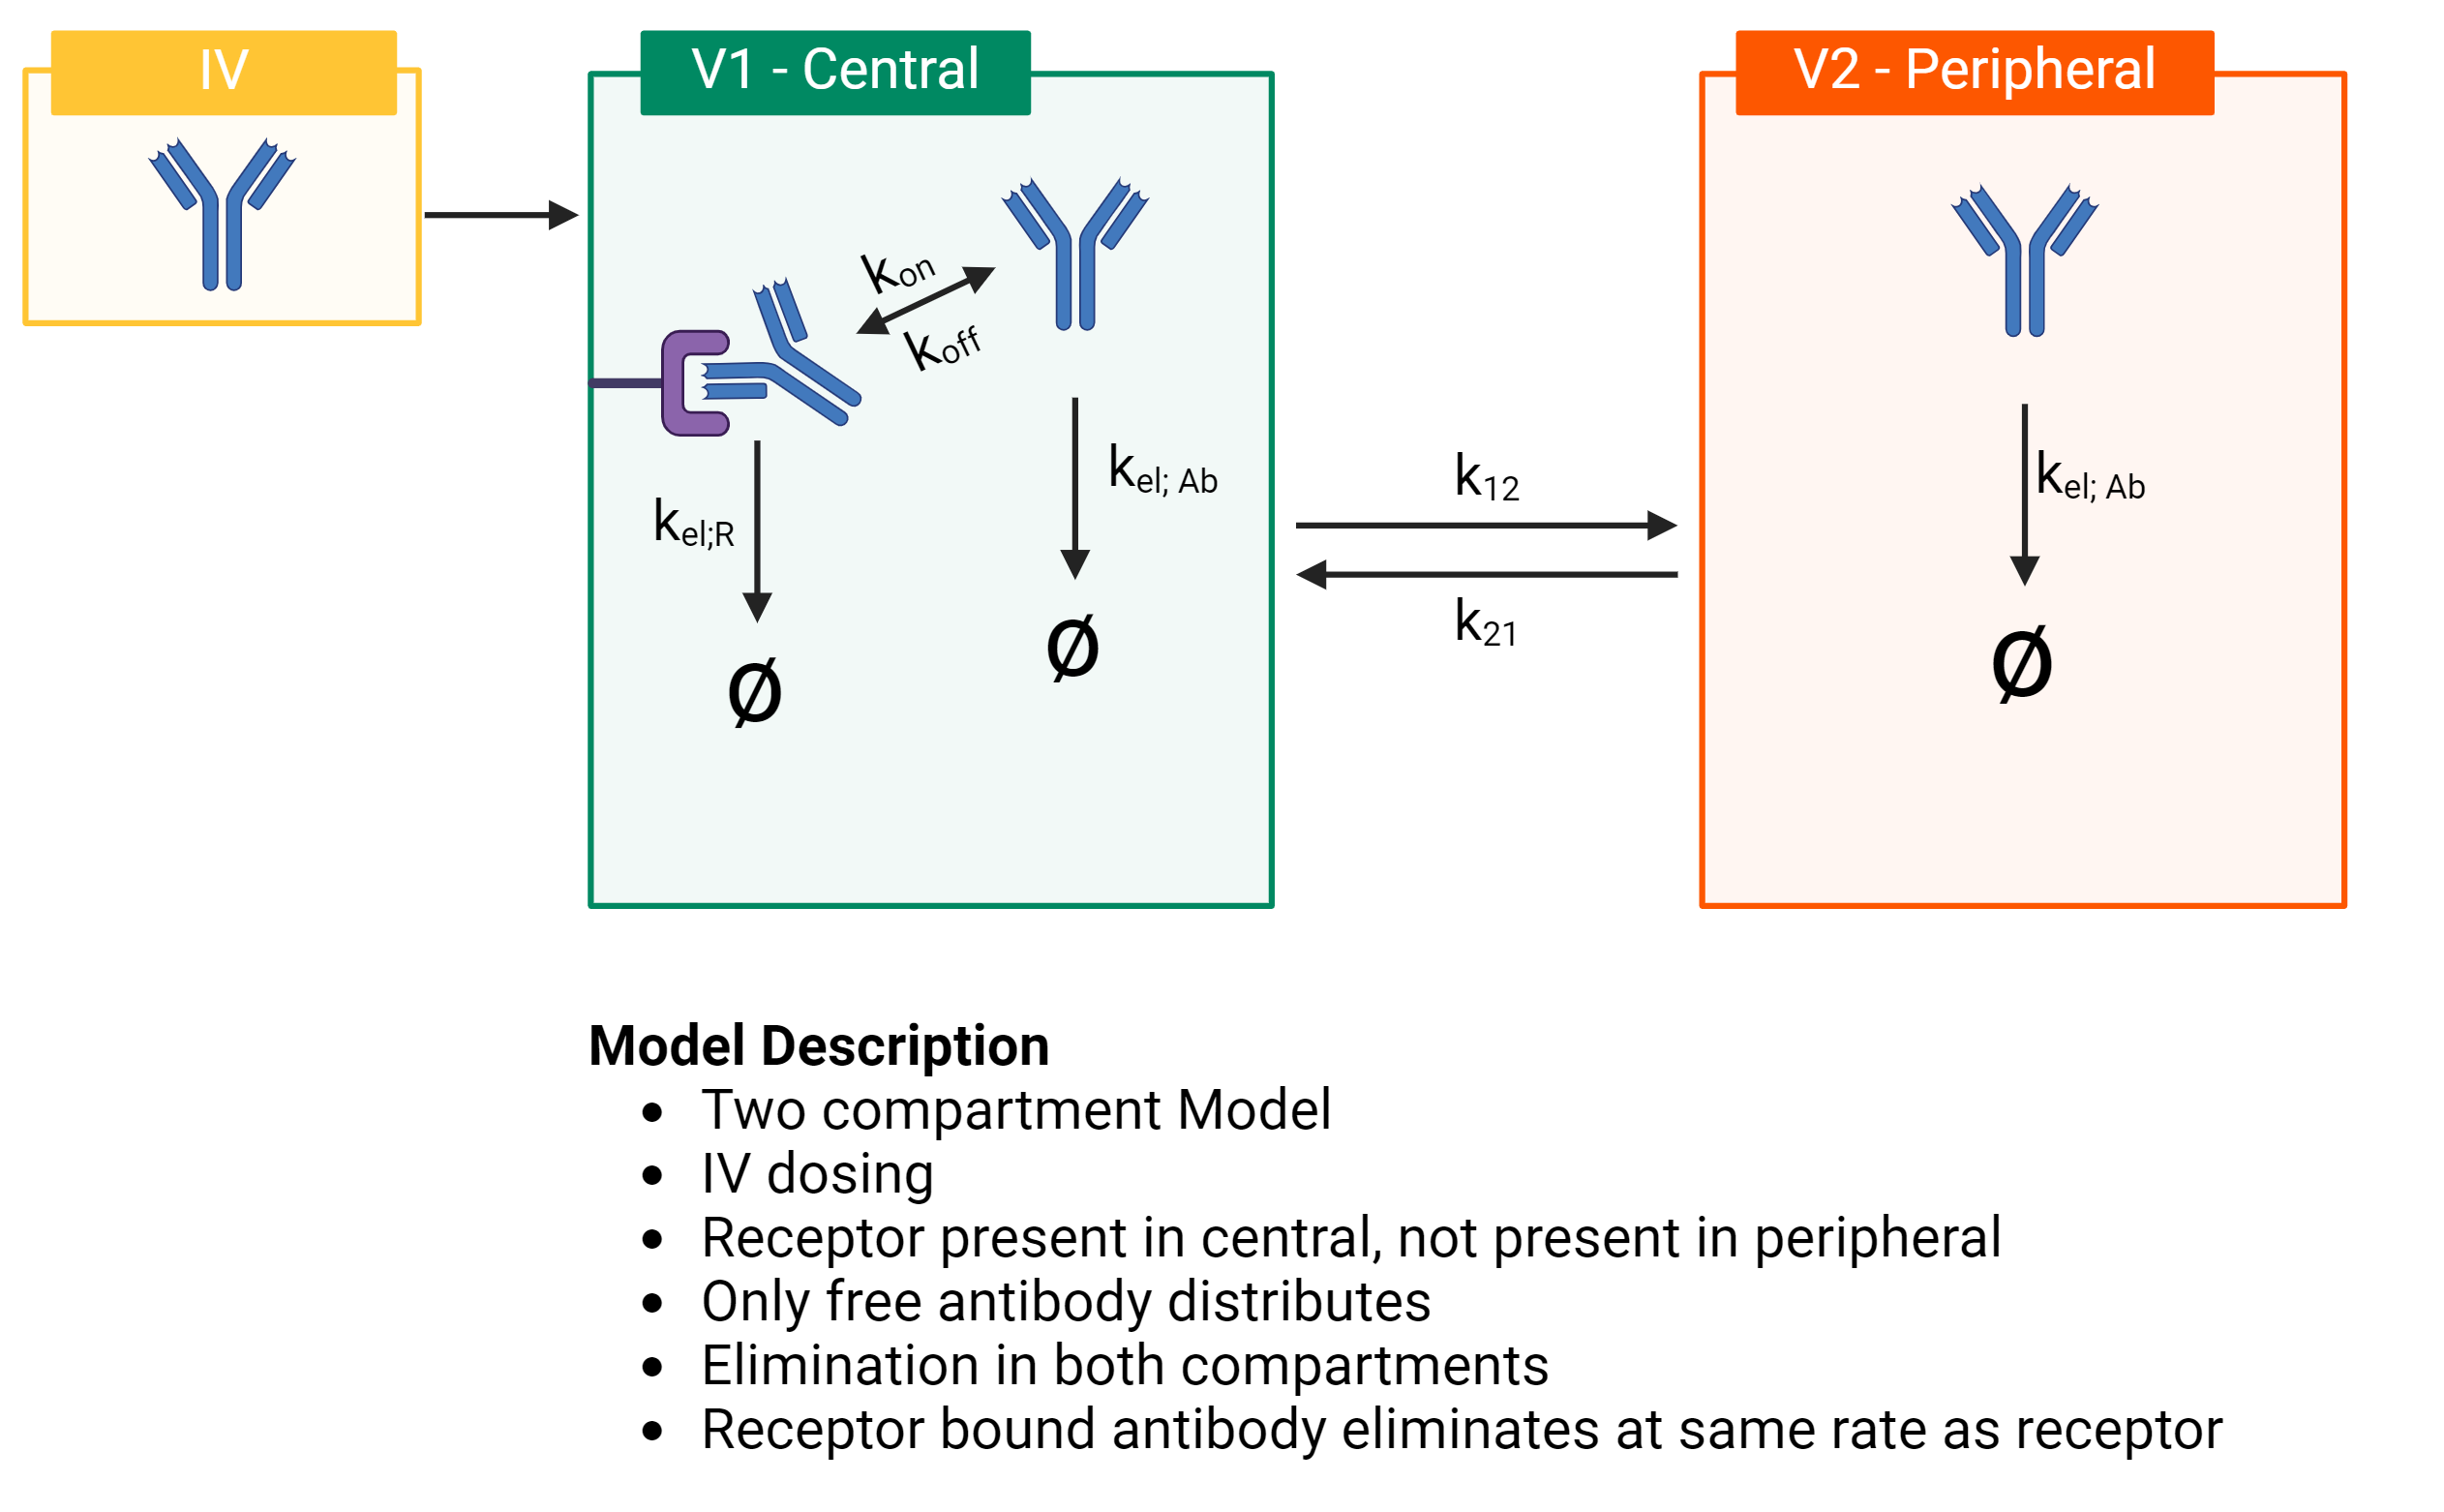

Model parameters fall into two broad categories, *microconstants*, i.e. the individual reaction rates, and *macroconstants* measured values that typically combine multiple reactions rates. For this example we will use *Macroconstant* parameters to describe all of these rates. Below is the list of relevant macroconstant parameters and their relationship to microconstant parameters:

| Macroconstant | Description | Conversion to microconstants |
|----------------|--------------|--------------------|
| \begin{align}\text{thalf}\end{align} | \begin{align}\text{Half life}\end{align} | $\text{kel} = \frac{\log(2)}{\text{thalf}}$|
| \begin{align}&\text{Pdist}\\& \\&\text{Tdist} \end{align}| \begin{align}& \text{Distribution partition}\\ & \\ & \text{Distribution half time} \end{align}| \begin{align} & \text{k12} = \frac{(\log(2) *  \text{Pdist})/\text{Tdist}}{(\text{Pdist} + (\text{V1}/\text{V2}))} \\ & \\ & \text{k21} = \frac{\log(2)/\text{Tdist}}{(1 + (\text{Pdist} * \text{V2}/\text{V1}))}\end{align}|
|\begin{align}\text{KD}\end{align} | \begin{align}\text{Affinity}\end{align}| $\text{koff} = \text{KD} * \text{kon}$|

It is entirely possible to build your model using the microconstants, but the modeling language supports macroconstants directly in a way that reduces the potential for errors.


In [1]:
# Code Preamble
import numpy as np
import pandas as pd
from plotnine import *
from abm import *

In [2]:
# Define model file location
model = 'models/Model_file.txt'

## Simulations


The most flexible method of defining simulation conditions (ie parameter values and dosing schedules) is through the use of parameter, dose, and simulation tables. These tables provide a large degree of flexibility and allow you to modify the model parameters and dosing schedules without editing the model file. 


### Two dosing schedules

One of the greatest strengths of the QSP Notebook simulation environment is the ability to include labels on different parameter sets or dosing regimes. This allows you to simultaneously define and run simulations for mutliple populations. In the first example we will look at the effect of two separate dosing schedules - a single dose and a repeat dose schedule. Pay attention to the dose and simulation tables to see how those schedules are defined.

In [3]:
# Load tables with parameter and dosing information
Tpar = pd.read_csv('tables/ParameterTable.csv')
Tdos = pd.read_csv('tables/DoseTable.csv')
Tsim = pd.read_csv('tables/SimulationTable.csv')

In [4]:
print('parameter table:')
display(Tpar)
print('\n dose table:')
display(Tdos)
print('\n simulation table')
display(Tsim)

parameter table:


,parameter,unit,value
0,volume_central,L,5.000
1,volume_peripheral,L,13.000
2,R_per_cell,1,10000.000
3,cell_per_mL,1/mL,1000000.000
4,kon,1/nM/s,0.001
5,kd_mab,nM,0.100
6,el_half,d,28.000
7,R_half,min,60.000
8,Pdist,1,0.120
9,Tdist_hr,hr,12.000



 dose table:


,dose_mpk,schedule,route,amounts,amount_unit,times,time_unit
0,0.01,repeat,IV_mpk,0.01,mg/kg,"[0,7,14]",d
1,0.03,repeat,IV_mpk,0.03,mg/kg,"[0,7,14]",d
2,0.10,repeat,IV_mpk,0.10,mg/kg,"[0,7,14]",d
3,0.30,repeat,IV_mpk,0.30,mg/kg,"[0,7,14]",d
4,0.01,single,IV_mpk,0.01,mg/kg,0,d
5,0.03,single,IV_mpk,0.03,mg/kg,0,d
6,0.10,single,IV_mpk,0.10,mg/kg,0,d
7,0.30,single,IV_mpk,0.30,mg/kg,0,d



 simulation table


,dose_mpk,schedule
0,0.01,repeat
1,0.03,repeat
2,0.10,repeat
3,0.30,repeat
4,0.01,single
5,0.03,single
6,0.10,single
7,0.30,single


In [5]:
Tres = simulate(models = model,
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)

display(Tres.head())

Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,schedule,id,t,output,value,output_unit
0,0.01,repeat,0,0.0,RO1,0.000000,1
1,0.01,repeat,0,8640.0,RO1,74.974506,1
2,0.01,repeat,0,17280.0,RO1,73.941215,1
3,0.01,repeat,0,25920.0,RO1,72.920454,1
4,0.01,repeat,0,34560.0,RO1,71.914931,1


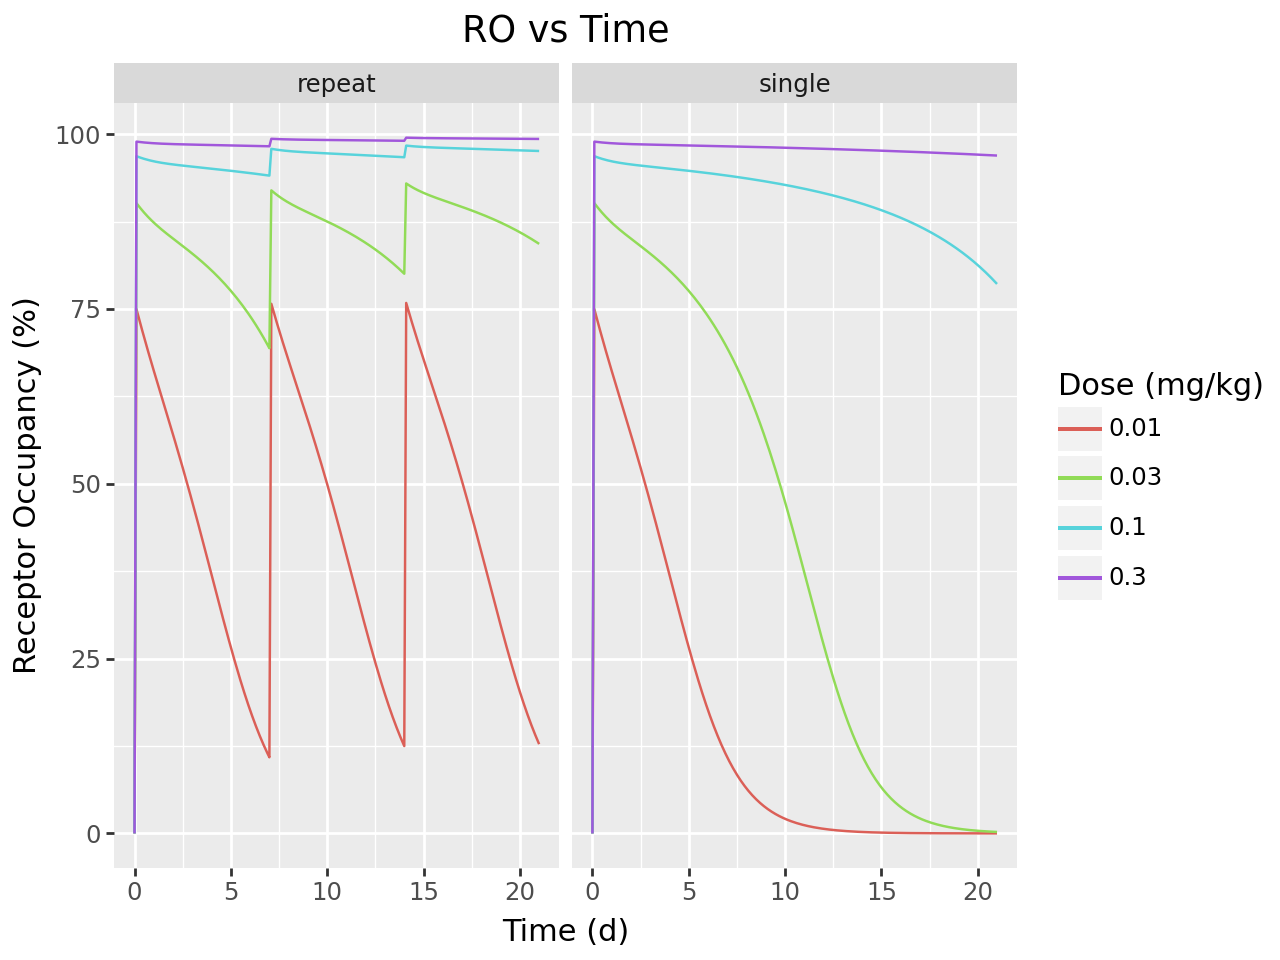

In [6]:
fig = (ggplot()
       + geom_line(data = Tres, mapping = aes(y = 'value', x = 't/(3600*24)', color = 'factor(dose_mpk)'))
       + labs(x = 'Time (d)', y = 'Receptor Occupancy (%)', color = 'Dose (mg/kg)', title = 'RO vs Time')
       + facet_wrap('schedule')
)

display(fig)

### Two populations

In addition to adding labels to dose and simulation tables, it is possible to include a label column within the parameter table. This allows you to run simulations for multiple distinct populations simultaneously.

In the following example we will simulate both single and repeat dosing for two populations (one with fast clearance and one with slow clearance). Note, you can use a "\*" to denote that a row can be applied to all options of column values in a parameter or dose table. All desired combinations of labels must be explicitely written in the simulation table (No "\*"s)

In [7]:
# Load tables with parameter and dosing information
Tpar_2pop = pd.read_csv('tables/ParameterTable_2populations.csv')
Tdos_2pop = pd.read_csv('tables/DoseTable_2populations.csv')
Tsim_2pop = pd.read_csv('tables/SimulationTable_2populations.csv')

In [8]:
print('parameter table:')
display(Tpar_2pop)
print('\n dose table:')
display(Tdos_2pop)
print('\n simulation table')
display(Tsim_2pop)

parameter table:


,parameter,clearance,unit,value
0,volume_central,*,L,5.000
1,volume_peripheral,*,L,13.000
2,R_per_cell,*,1,10000.000
3,cell_per_mL,*,1/mL,1000000.000
4,kon,*,1/nM/s,0.001
5,kd_mab,*,nM,0.100
6,el_half,fast,d,14.000
7,el_half,slow,d,28.000
8,R_half,*,min,60.000
9,Pdist,*,1,0.120



 dose table:


,dose_mpk,schedule,clearance,route,amounts,amount_unit,times,time_unit
0,0.01,repeat,*,IV_mpk,0.01,mg/kg,"[0,7,14]",d
1,0.03,repeat,*,IV_mpk,0.03,mg/kg,"[0,7,14]",d
2,0.10,repeat,*,IV_mpk,0.10,mg/kg,"[0,7,14]",d
3,0.30,repeat,*,IV_mpk,0.30,mg/kg,"[0,7,14]",d
4,0.01,single,*,IV_mpk,0.01,mg/kg,0,d
5,0.03,single,*,IV_mpk,0.03,mg/kg,0,d
6,0.10,single,*,IV_mpk,0.10,mg/kg,0,d
7,0.30,single,*,IV_mpk,0.30,mg/kg,0,d



 simulation table


,dose_mpk,clearance,schedule
0,0.01,fast,repeat
1,0.03,fast,repeat
2,0.10,fast,repeat
3,0.30,fast,repeat
4,0.01,fast,single
5,0.03,fast,single
6,0.10,fast,single
7,0.30,fast,single
8,0.01,slow,repeat
9,0.03,slow,repeat


In [9]:
Tres_2pop = simulate(models = model,
                parameters = Tpar_2pop,
                doses = Tdos_2pop,
                simulations = Tsim_2pop,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)

display(Tres_2pop.head())

Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,clearance,schedule,id,t,output,value,output_unit
0,0.01,fast,repeat,0,0.0,RO1,0.000000,1
1,0.01,fast,repeat,0,8640.0,RO1,74.932567,1
2,0.01,fast,repeat,0,17280.0,RO1,73.849681,1
3,0.01,fast,repeat,0,25920.0,RO1,72.776053,1
4,0.01,fast,repeat,0,34560.0,RO1,71.714445,1


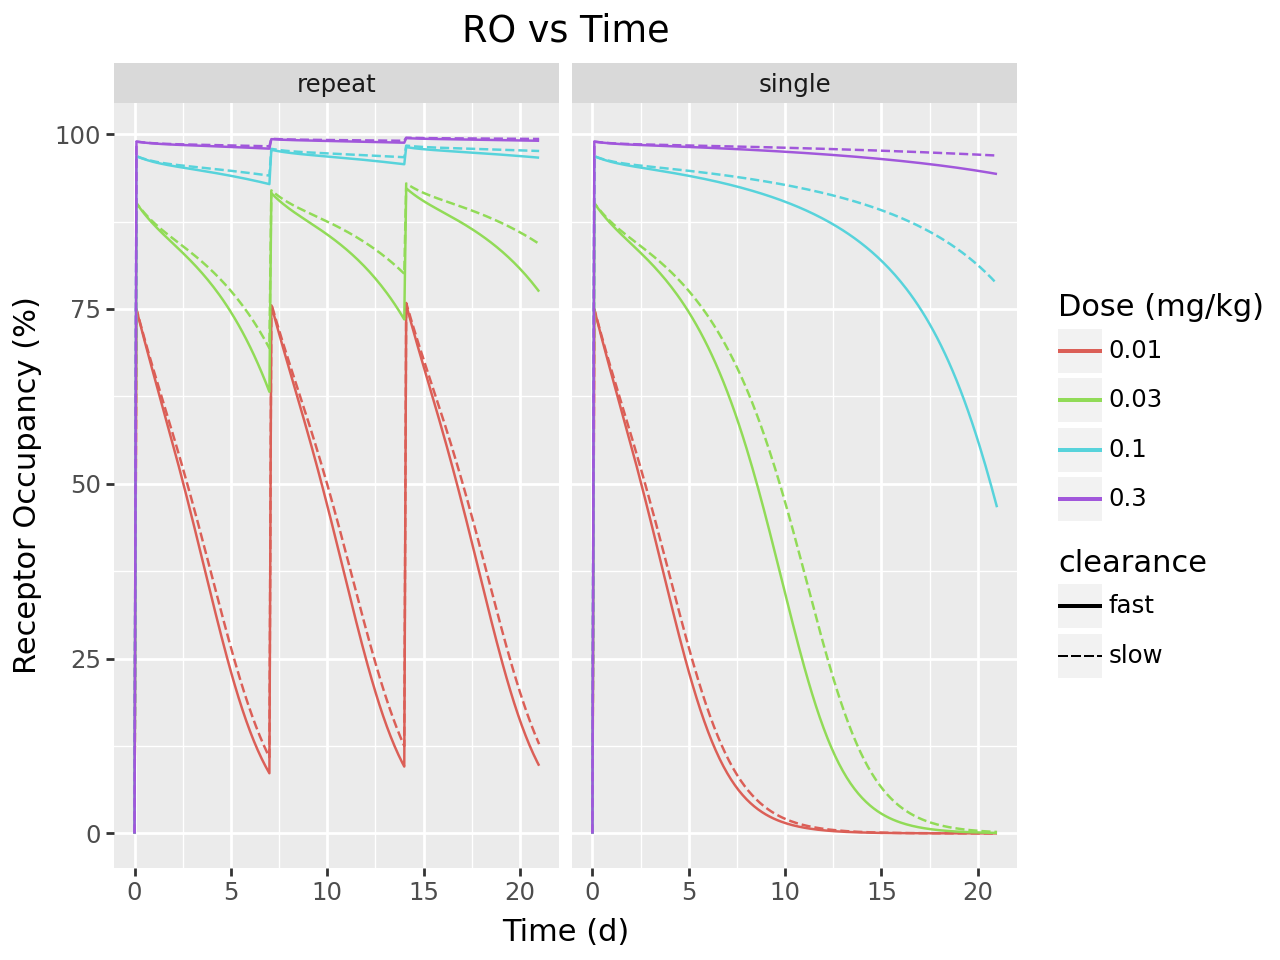

In [10]:
fig = (ggplot()
       + geom_line(data = Tres_2pop, mapping = aes(y = 'value', x = 't/(3600*24)', color = 'factor(dose_mpk)',
                                                  linetype = 'clearance'))
       + labs(x = 'Time (d)', y = 'Receptor Occupancy (%)', color = 'Dose (mg/kg)', title = 'RO vs Time')
       + facet_wrap('schedule')
)

display(fig)

## Parameter scans

Another feature of the QSP Notebook Simulate function is the ability to run parameter scans. There are resources in repository demonstrating the way parameter scans can be combined. In this notebook we will focus on two examples of 1D parameter scans.

### Single parameter scan

In this example we will scan a single parameter (Affinity) over a two fold increase and decrease. We will see how the change in parameter value will affect the time dynamics of receptor occupancy as a function of this parameter change.

In [11]:
# grab one repeated dose for this example
Tsim_scan = Tsim.query('dose_mpk == 0.1 and schedule == "repeat"')
display(Tsim_scan)

,dose_mpk,schedule
2,0.1,repeat


In [12]:
# Fold scan over affinity
Tfold = simulate(models = model,
                parameters = Tpar,
                doses = Tdos,
                simulations = Tsim_scan,
                outputs = ['RO1'],
                times = linspace(0,21,211,'d'),
                scans = fold_scan(kd_mab = [0.5, 1, 2])).to_pandas(tall_outputs = True)

display(Tfold.head())

Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,schedule,scan_0_type,id,param_scan_0,scan_0_value,scan_0_fold,t,output,value,output_unit
0,0.1,repeat,fold,0,kd_mab,0.05,0.5,0.0,RO1,0.000000,1
1,0.1,repeat,fold,0,kd_mab,0.05,0.5,8640.0,RO1,97.371791,1
2,0.1,repeat,fold,0,kd_mab,0.05,0.5,17280.0,RO1,97.284497,1
3,0.1,repeat,fold,0,kd_mab,0.05,0.5,25920.0,RO1,97.202270,1
4,0.1,repeat,fold,0,kd_mab,0.05,0.5,34560.0,RO1,97.125054,1


/opt/pixi/cache/envs/abm-platform-training-11393412784987863449/envs/default/lib/python3.12/site-packages/plotnine/geoms/geom_path.py:99: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


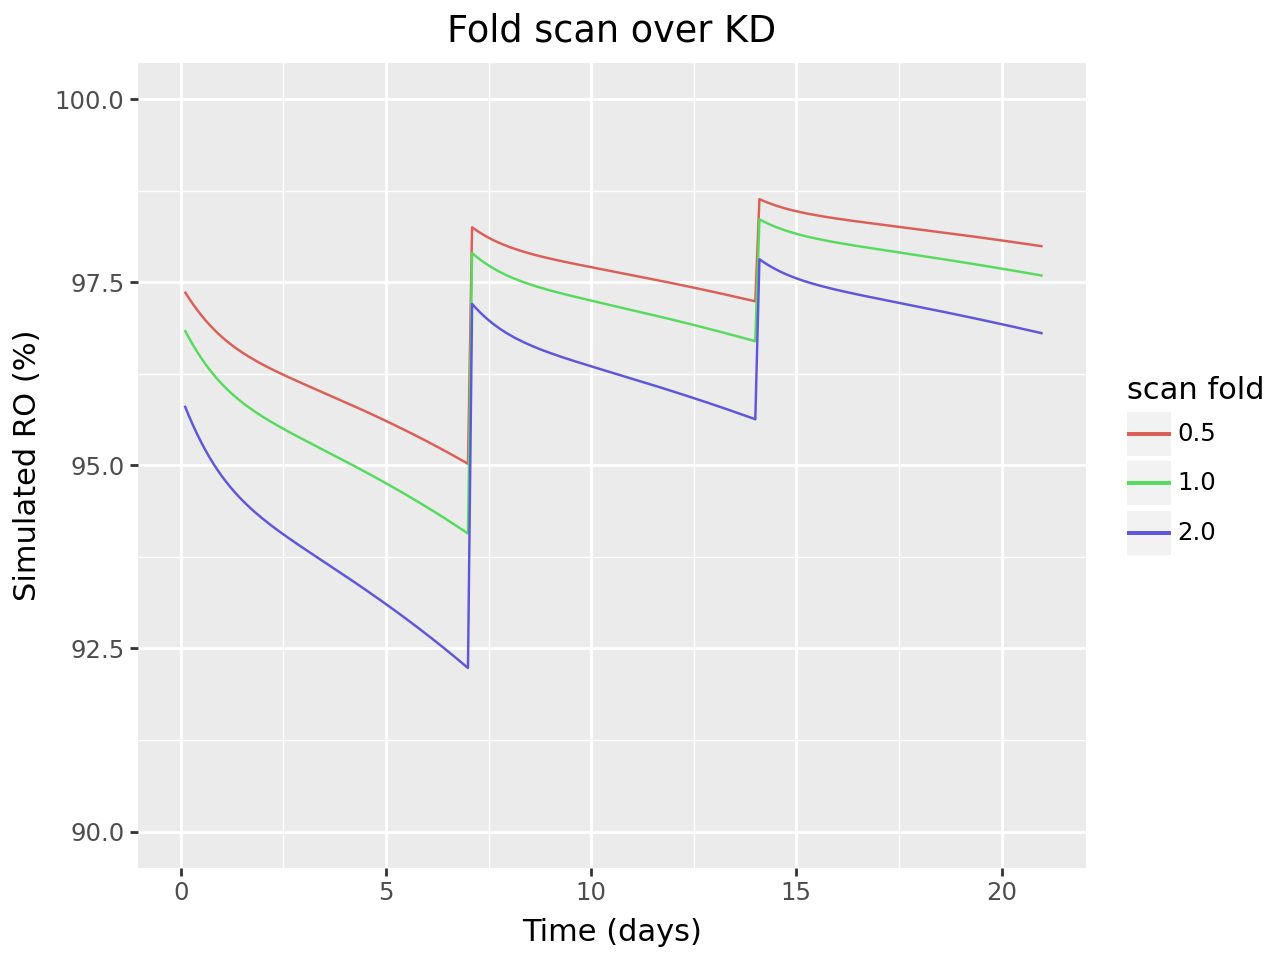

In [13]:
fig = (ggplot()
       + geom_line(data = Tfold, mapping = aes(x = 't/(3600*24)', y = 'value', color = 'factor(scan_0_fold)'))
       + labs(x = 'Time (days)', y = 'Simulated RO (%)', color = 'scan fold', title = 'Fold scan over KD')
       + scale_y_continuous(limits = [90,100])
)

fig.show()

### One at a time sensitivity

In the following example we will perform a local sensitivity analysis by scanning 10 parameters (all except body weight and molecular weight). The output of this block of code will be a tornado plot which shows how the desired summary statistic (terminal RO in this case) responds to changes in each of the parameters.

In [14]:
Tsens = simulate(models = model,
        parameters = Tpar,
        doses = Tdos,
        simulations = Tsim_scan,
        outputs = ['RO1'],
        times = ['21:d'],
        scans = fold_scan(volume_central = [0.5, 1, 2])
                 + fold_scan(volume_peripheral = [0.5, 1, 2])
                 + fold_scan(R_per_cell = [0.5, 1, 2])
                 + fold_scan(cell_per_mL = [0.5, 1, 2])
                 + fold_scan(kon = [0.5, 1, 2])
                 + fold_scan(kd_mab = [0.5, 1, 2])
                 + fold_scan(el_half = [0.5, 1, 2])
                 + fold_scan(R_half = [0.5, 1, 2])
                 + fold_scan(Pdist = [0.5, 1, 2])
                 + fold_scan(Tdist_hr = [0.5, 1, 2])
                ).to_pandas(tall_outputs = True)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

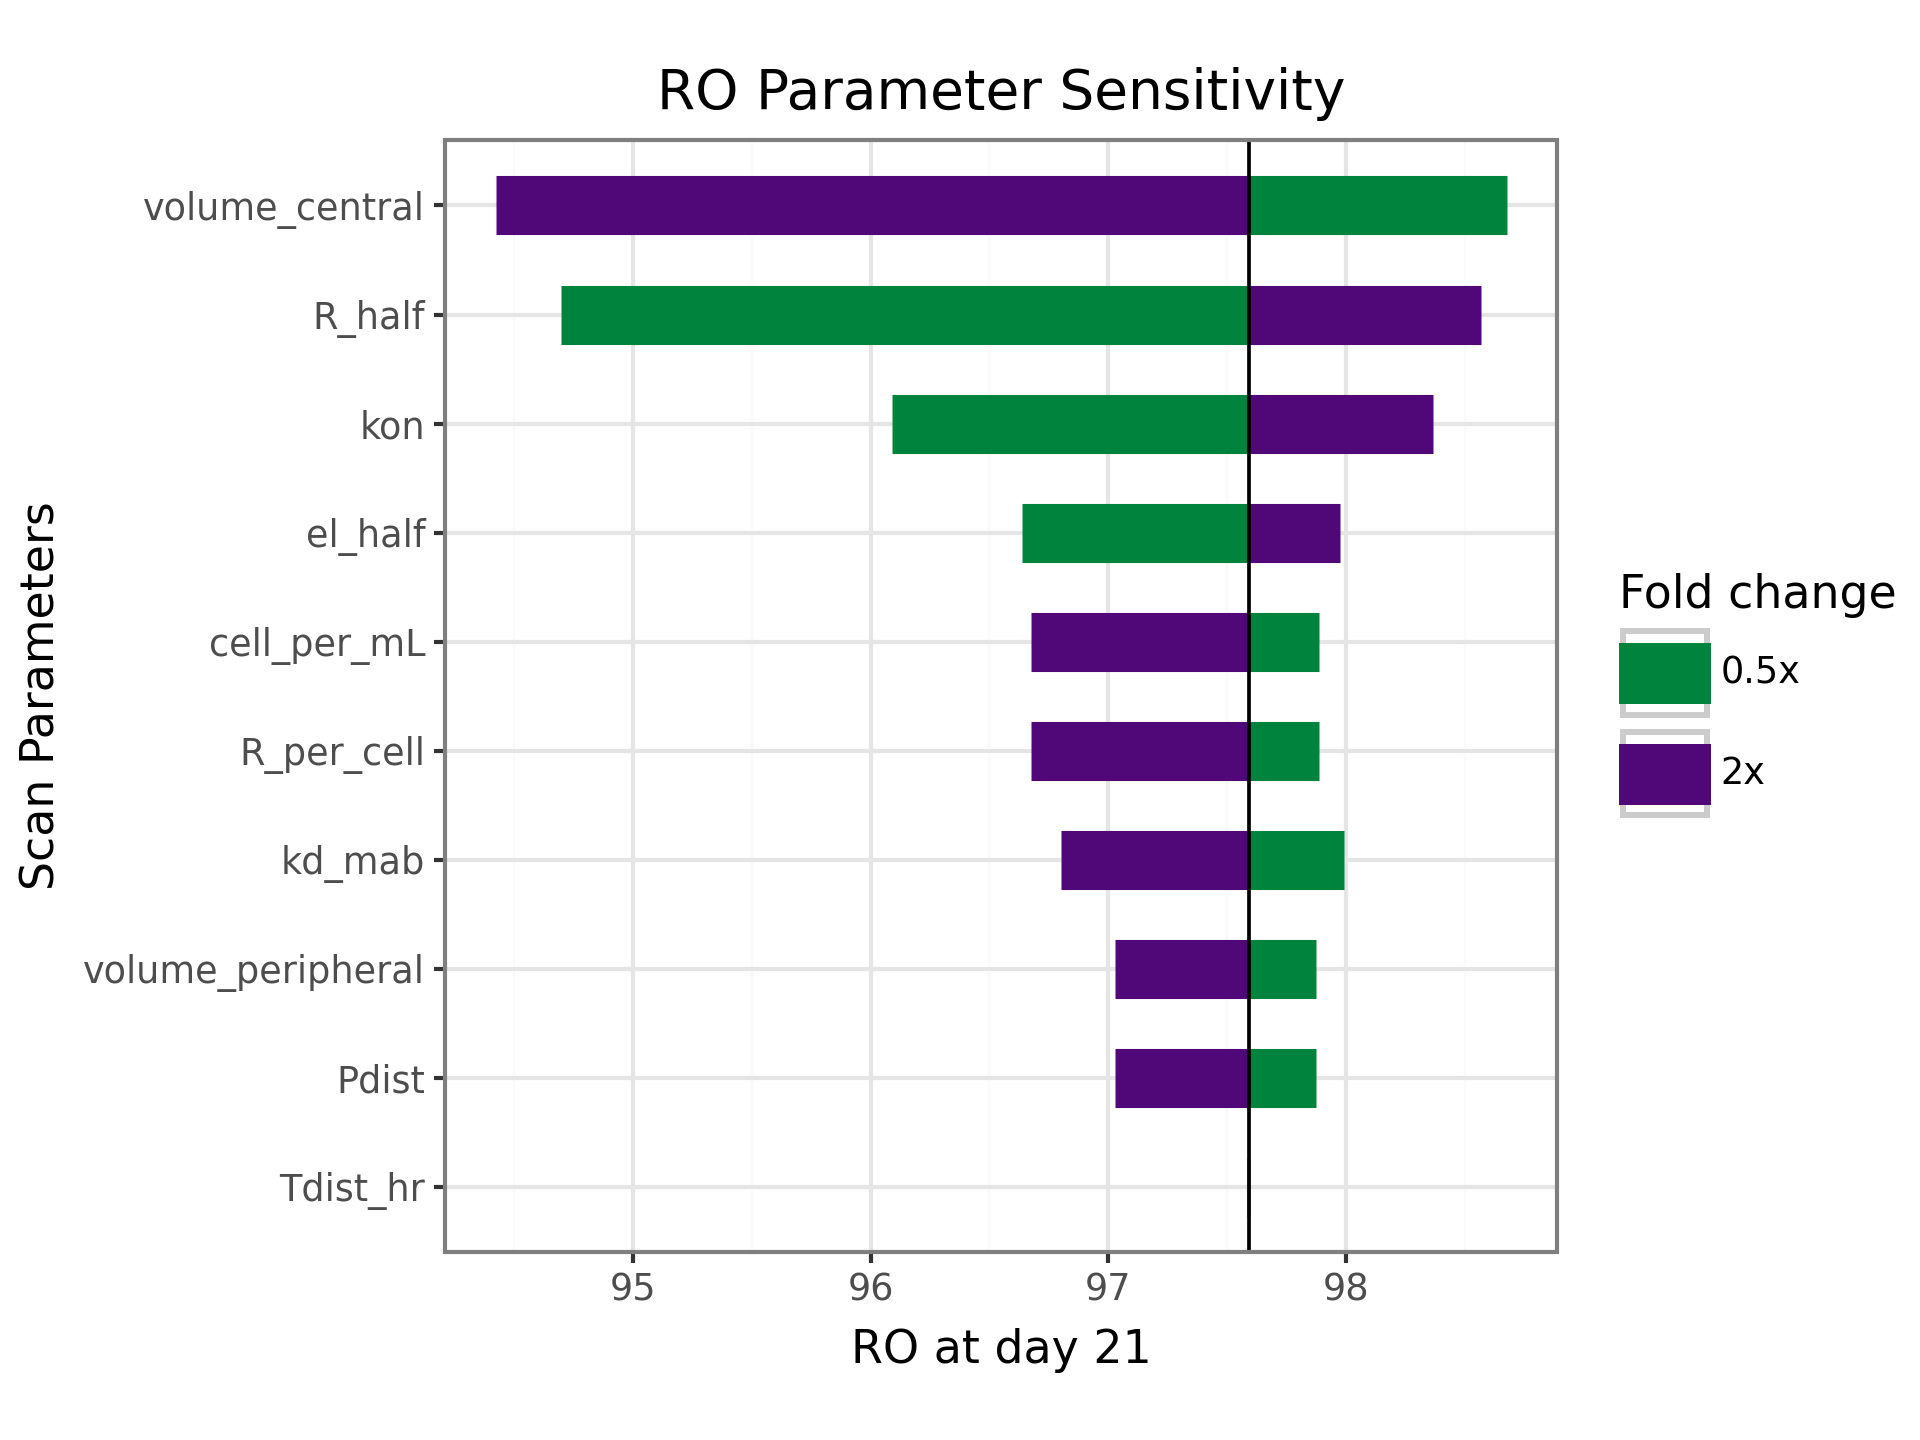

In [15]:
# Get the nominal output value
nominal_value = Tsens.value[Tsens.scan_0_fold == 1.].reset_index(drop = True)[0]

# Get table with parameters ordered as they should appear in the tornado plot
par_ranges = (
    Tsens
    .groupby('param_scan_0') # For each parameter...
    ['value'] # ...take the value column...
    .apply(lambda val: max(val)-min(val)) # ...and calculate the difference between the max and min value
    .sort_values() # Sort parameters by the result
)
ordered_pars = par_ranges.index.tolist()

# Construct the plot
(
    ggplot(Tsens.query('scan_0_fold != 1'))
    
    # Colored segments connecting the points
    + geom_segment(
        aes(x='value', xend='nominal_value', 
            y='param_scan_0', yend='param_scan_0',
            color = 'factor(scan_0_fold)'),
        size = 8
    )
    
    
    # Nominal line
    + geom_vline(xintercept = nominal_value)
    
    # Set colors and their labels
    + scale_color_manual(
        values = ['#00843D', '#500778'],
        labels = lambda xs: [f"{xi:g}x" for xi in xs] # Function converts list of numbers to "{number}x"
    )
    
    # Order the parameters for the "tornado" shape
    + scale_y_discrete(limits = ordered_pars) # For a discrete scale, setting limits sets the order of values
    
    + labs(x = "RO at day 21", y = "Scan Parameters", color = "Fold change",
           title = "RO Parameter Sensitivity")
    + theme_bw()
    + theme(aspect_ratio = 1, dpi=150)
)

## Optimization

The QSP Notebook allows access to state of the art optimization algorithms for systems models.

In the following example we will plot data, demonstrate the simulations given by the nominal parameter set, run an optimization to the data, and then demonstrate the simulations given by the optimized parameter set.

There are more details in other examples within this repository on how exactly to set up optimizations.

In [16]:
# Load data
Tdat = pd.read_csv('tables/Data.csv')
display(Tdat.head())

,dose_mpk,schedule,output,time,time_unit,measurement,measurement_unit,proportional_error,constant_error,constant_error_unit
0,0.01,repeat,RO1,0.5,hr,48.703860,1,0.0,5,1
1,0.01,repeat,free_drug1_central,0.5,hr,4.555469,(nmol),0.1,0,nmol
2,0.01,repeat,RO1,1.0,hr,50.153978,1,0.0,5,1
3,0.01,repeat,free_drug1_central,1.0,hr,4.481521,(nmol),0.1,0,nmol
4,0.01,repeat,RO1,7.0,hr,45.762040,1,0.0,5,1


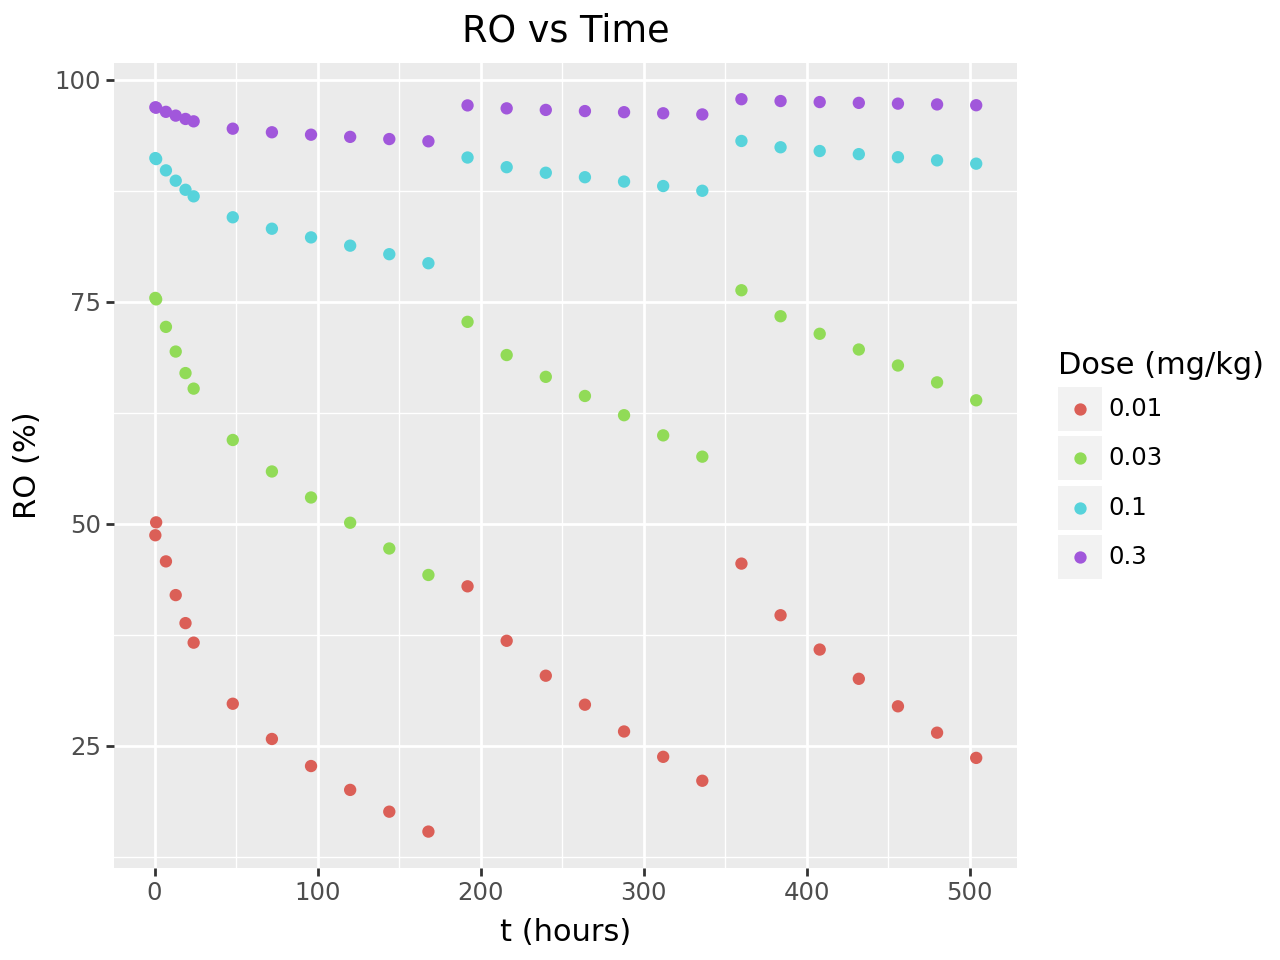

In [17]:
fig = (ggplot()
       + geom_point(data = Tdat.query('output == "RO1"'), mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

In [18]:
#pull out dosing information from data table

Tdos_fit = Tdat.copy()[['dose_mpk', 'schedule']].drop_duplicates()
Tdos_fit = Tdos_fit.assign(amounts = Tdos_fit.dose_mpk, amount_unit = "mg/kg", times = [[0, 7, 14]]*len(Tdos_fit.dose_mpk.unique()),
                    time_unit = 'd', route = 'IV_mpk')

display(Tdos_fit)

,dose_mpk,schedule,amounts,amount_unit,times,time_unit,route
0,0.01,repeat,0.01,mg/kg,"[0, 7, 14]",d,IV_mpk
52,0.03,repeat,0.03,mg/kg,"[0, 7, 14]",d,IV_mpk
104,0.10,repeat,0.10,mg/kg,"[0, 7, 14]",d,IV_mpk
156,0.30,repeat,0.30,mg/kg,"[0, 7, 14]",d,IV_mpk


In [19]:
#update parameter table for fitting purposes

Tpar_fit = Tpar.copy().assign(is_fit = False, lower_bound = Tpar.value, upper_bound = Tpar.value)

fit_dict = {'el_half': [7, 49],
            'Pdist': [0, 1],
            'kd_mab' : [0.01, 10]}

for par in fit_dict.keys():
    Tpar_fit.loc[Tpar_fit.parameter == par, 'lower_bound'] = fit_dict[par][0]
    Tpar_fit.loc[Tpar_fit.parameter == par, 'upper_bound'] = fit_dict[par][1]
    Tpar_fit.loc[Tpar_fit.parameter == par, 'is_fit'] = True

display(Tpar_fit)

,parameter,unit,value,is_fit,lower_bound,upper_bound
0,volume_central,L,5.000,False,5.000,5.000
1,volume_peripheral,L,13.000,False,13.000,13.000
2,R_per_cell,1,10000.000,False,10000.000,10000.000
3,cell_per_mL,1/mL,1000000.000,False,1000000.000,1000000.000
4,kon,1/nM/s,0.001,False,0.001,0.001
5,kd_mab,nM,0.100,True,0.010,10.000
6,el_half,d,28.000,True,7.000,49.000
7,R_half,min,60.000,False,60.000,60.000
8,Pdist,1,0.120,True,0.000,1.000
9,Tdist_hr,hr,12.000,False,12.000,12.000


In [20]:
# Simulate Nominal Parameters
Tnominal = simulate(models = model,
                parameters = Tpar,
                doses = Tdos_fit,
                simulations = Tdos_fit[['dose_mpk', 'schedule']],
                outputs = ['RO1', 'free_drug1_central'],
                times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

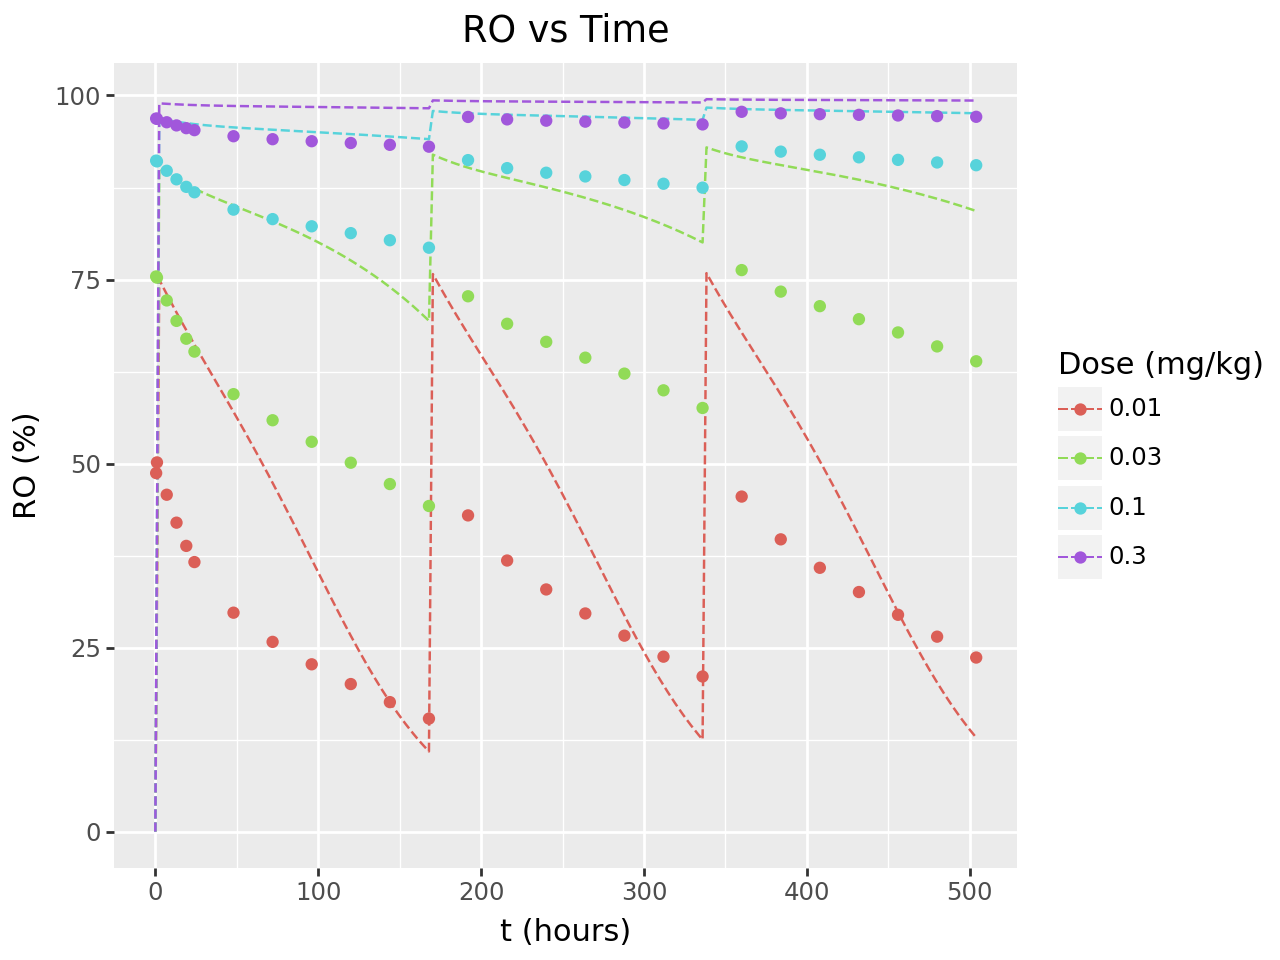

In [21]:
#Show nominal values
#Plot simulation vs data - RO
fig = (ggplot()
       + geom_line(data = Tnominal.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'), linetype = 'dashed')
       + geom_point(data = Tdat.query('output == "RO1"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

In [22]:
#Fit Parameters

optimization = optimize(
    measurements = Tdat,
    models = model,
    parameters = Tpar_fit,
    doses = Tdos,
)

Total: 0, Running: 0, Succeeded: 0, Failed: 0

iteration,objective,kd_mab_fit_5,el_half_fit_6,Pdist_fit_8
0,8432.764739,0.100000,28.000000,0.120000
1,733.258103,0.732329,31.655176,0.195461
2,733.258103,0.732329,31.655176,0.195461
3,507.133176,0.697700,26.544084,0.253493
4,507.133176,0.697700,26.544084,0.253493
5,458.914643,0.683596,24.672048,0.285951
6,458.914643,0.683596,24.672048,0.285951
7,454.823701,0.717967,23.743151,0.299064
8,454.823701,0.717967,23.743151,0.299064
9,454.052502,0.696057,23.762516,0.299709


In [23]:
#Display Parameters
Tpar_result = optimization.fit_parameter_table.to_pandas()

display(Tpar_result.query('is_fit == True'))

,parameter,unit,value,is_fit,lower_bound,upper_bound,global_parameter_name
5,kd_mab,nM,0.692246,True,0.01,10.0,kd_mab_fit_5
6,el_half,d,25.191756,True,7.00,49.0,el_half_fit_6
8,Pdist,1,0.308327,True,0.00,1.0,Pdist_fit_8


In [24]:
#simulate result of optimization
Tres_fit = optimization.simulate(times = linspace(0,21,211,'d')).to_pandas(tall_outputs = True)
display(Tres.head())

Total: 0, Running: 0, Succeeded: 0, Failed: 0

,dose_mpk,schedule,id,t,output,value,output_unit
0,0.01,repeat,0,0.0,RO1,0.000000,1
1,0.01,repeat,0,8640.0,RO1,74.974506,1
2,0.01,repeat,0,17280.0,RO1,73.941215,1
3,0.01,repeat,0,25920.0,RO1,72.920454,1
4,0.01,repeat,0,34560.0,RO1,71.914931,1


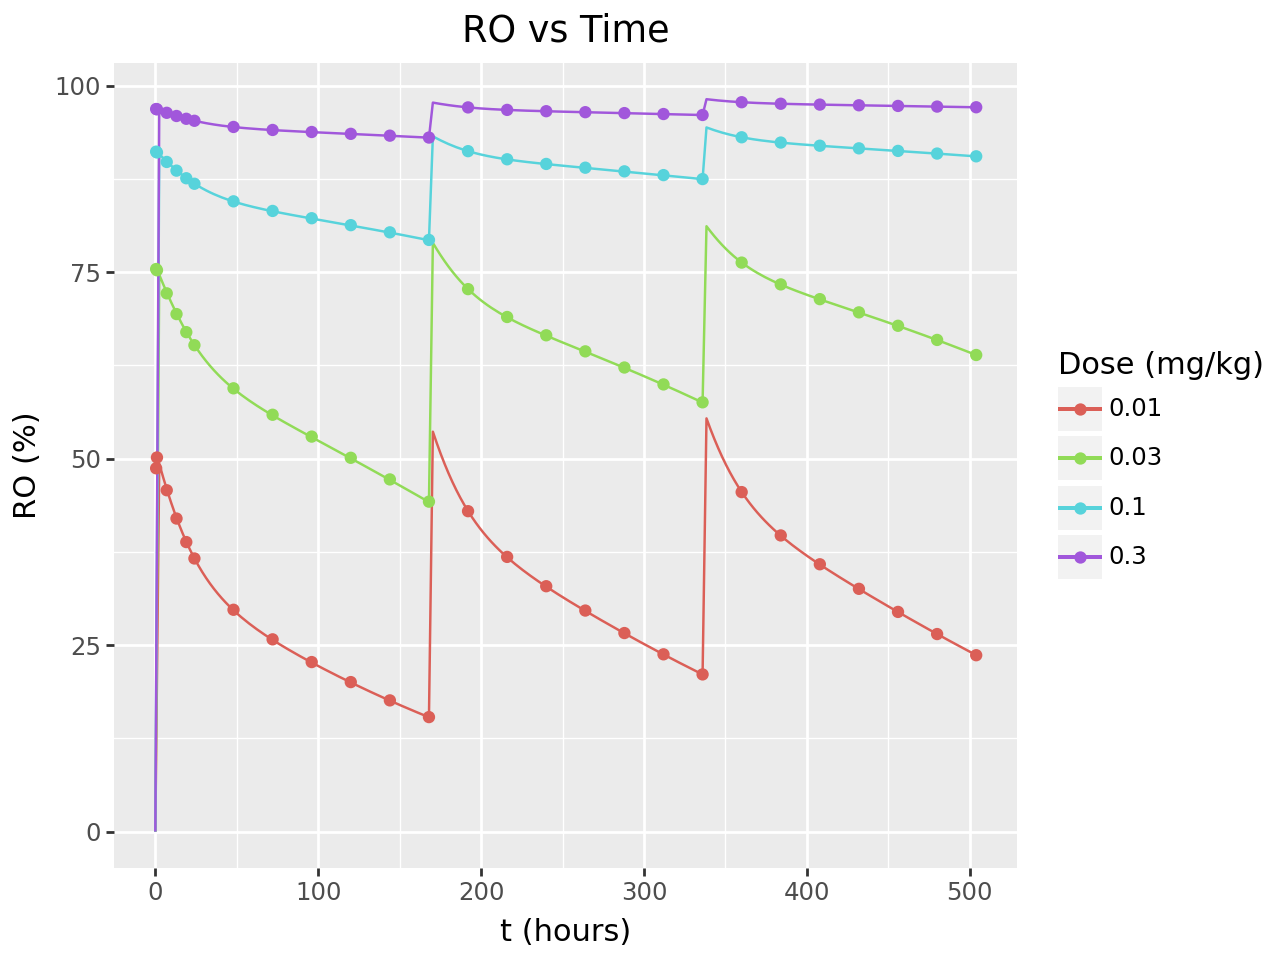

In [25]:
#Plot Simulations vs Data - RO
fig = (ggplot()
       + geom_line(data = Tres_fit.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)'))
       + geom_point(data = Tdat.query('output == "RO1"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)')
)

fig.show()

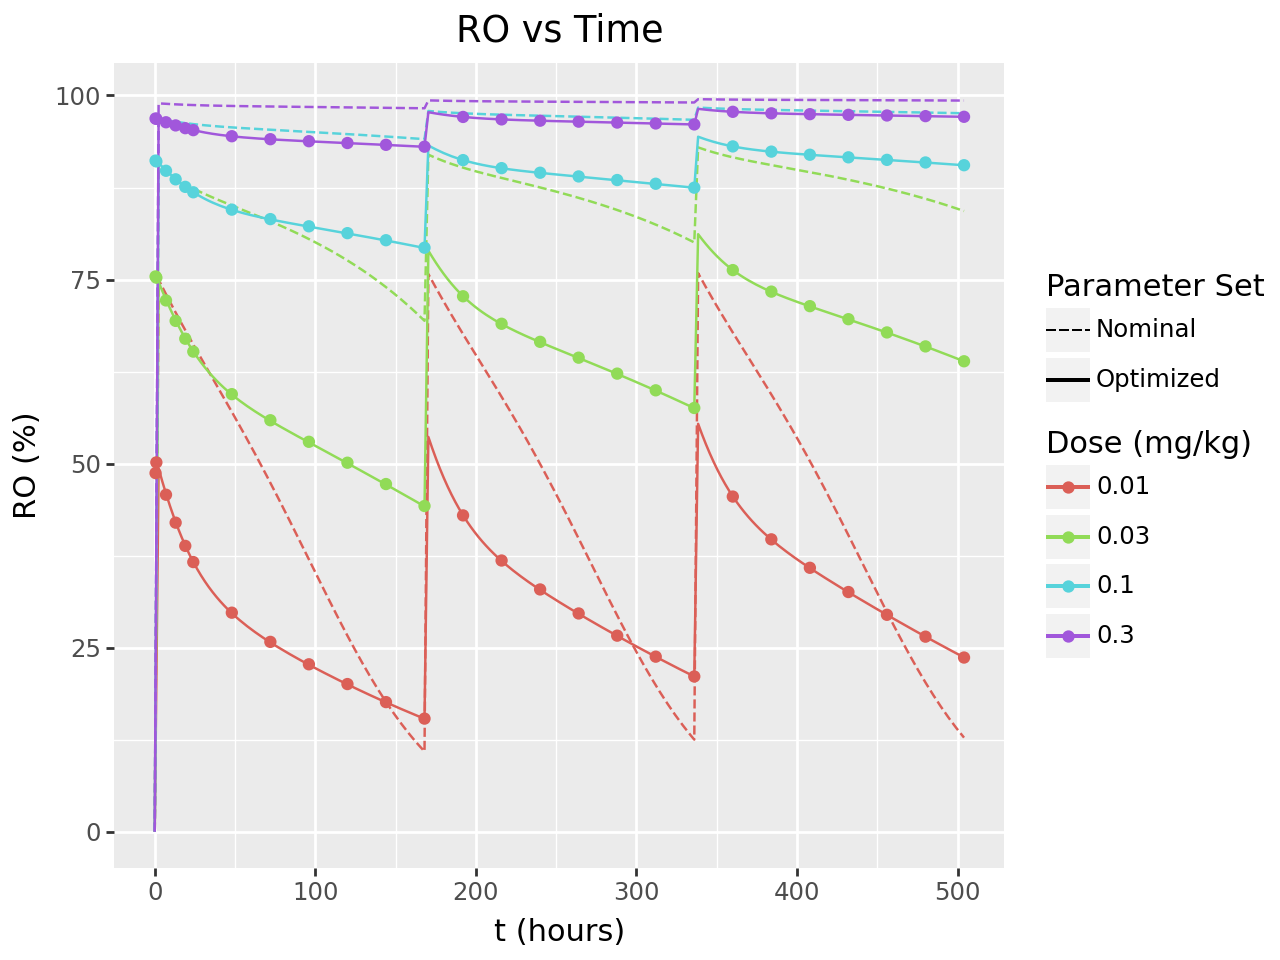

In [26]:
#Show improvement over nominal values
Tcompare = pd.concat([Tres_fit.assign(source = 'Optimized'), Tnominal.assign(source = 'Nominal')])

#Plot simulation vs data - RO
fig = (ggplot()
       + geom_line(data = Tcompare.query('output == "RO1"'),
                   mapping = aes(x = 't/(3600)', y = 'value', color = 'factor(dose_mpk)', linetype = 'source'))
       + geom_point(data = Tdat.query('output == "RO1"'),
                    mapping = aes(x = 'time', y = 'measurement', color = 'factor(dose_mpk)'))
       + scale_linetype_manual(['dashed','solid'])
       + labs(title = 'RO vs Time', x = 't (hours)', y = 'RO (%)', color = 'Dose (mg/kg)', linetype = 'Parameter Set')
)

fig.show()